In [82]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
def get_fpl_data():
    base_url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    response = requests.get(base_url)
    data = response.json()
    return data

In [95]:
fpl_data = get_fpl_data()

In [96]:
fpl_data.keys()

dict_keys(['chips', 'events', 'game_settings', 'game_config', 'phases', 'teams', 'total_players', 'element_stats', 'element_types', 'elements'])

In [113]:
teams_data = fpl_data['teams']
players_data = fpl_data['elements']
gameweek_data = fpl_data['events']
chips = fpl_data['chips']
game_config = fpl_data['game_config']

In [114]:
mapping = {1: "gk", 2: "def", 3: "mid", 4: "att"}  

In [126]:
players_data[0].keys()

dict_keys(['can_transact', 'can_select', 'chance_of_playing_next_round', 'chance_of_playing_this_round', 'code', 'cost_change_event', 'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo', 'points_per_game', 'removed', 'second_name', 'selected_by_percent', 'special', 'squad_number', 'status', 'team', 'team_code', 'total_points', 'transfers_in', 'transfers_in_event', 'transfers_out', 'transfers_out_event', 'value_form', 'value_season', 'web_name', 'region', 'team_join_date', 'birth_date', 'has_temporary_code', 'opta_code', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'clearances_blocks_interceptions', 'recoveries', 'tackles', 'defen

In [137]:
players_data_df = pd.DataFrame(players_data)

In [138]:
players_data_df = players_data_df[['total_points', 'element_type', 'goals_scored', 'bps','assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'influence', 'creativity', 'threat', 'ict_index', 'clearances_blocks_interceptions', 'recoveries', 'tackles', 'defensive_contribution', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'form', 'starts', 'minutes']]
players_data_df["element_type"] = players_data_df["element_type"].map(mapping).fillna("unknown")

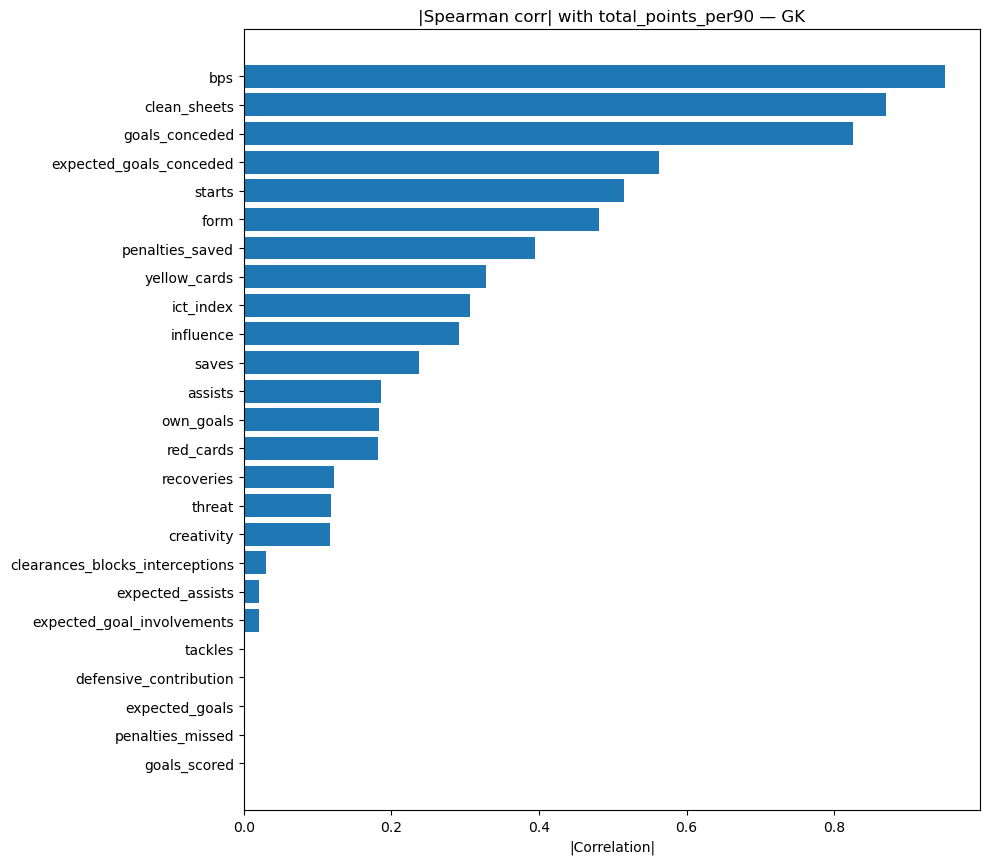

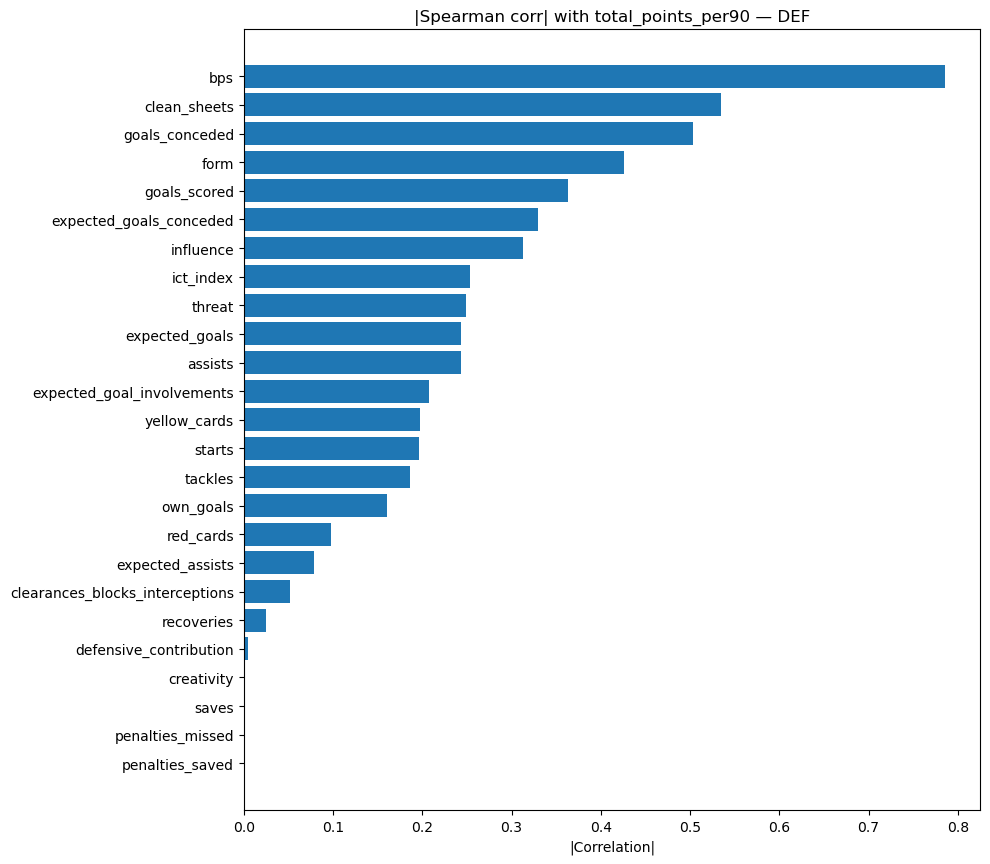

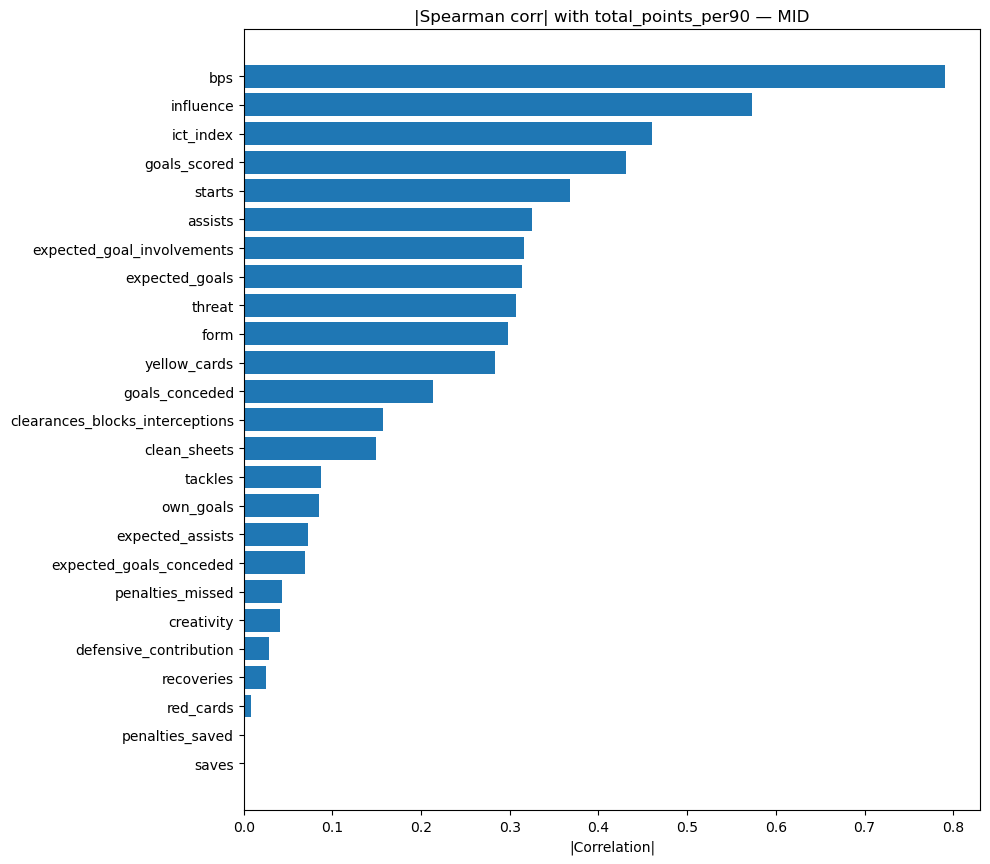

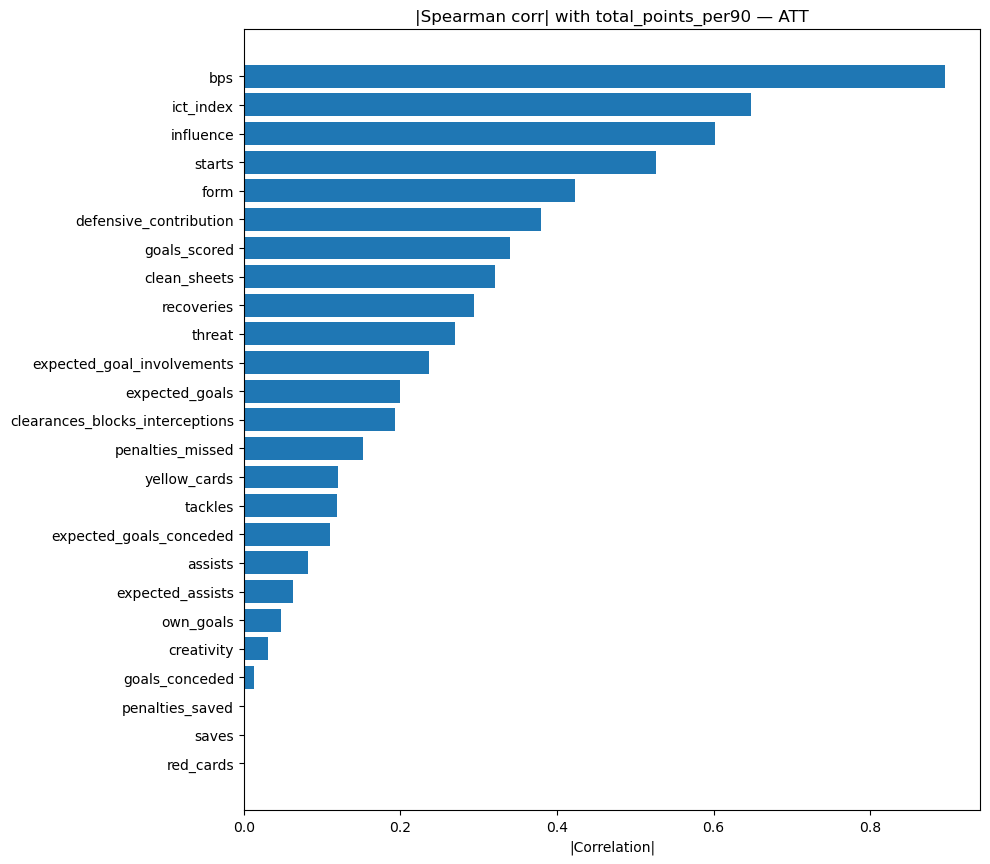

In [148]:
def corr_plots_by_position_per90_abs(
    df: pd.DataFrame,
    group_col: str = "element_type",
    target: str = "total_points",
    minutes_col: str = "minutes",
    positions=("gk", "def", "mid", "att"),
    method: str = "spearman",
):
    d = df.copy()

    for c in d.columns:
        if c != group_col:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    num_cols = d.select_dtypes(include="number").columns
    if target not in num_cols or minutes_col not in num_cols:
        raise ValueError(f"'{target}' and '{minutes_col}' must be numeric columns in df.")

    denom = d[minutes_col].replace(0, np.nan) / 90.0
    per90 = d[num_cols].div(denom, axis=0)
    per90[minutes_col] = d[minutes_col]

    features = [c for c in num_cols if c not in (target, minutes_col)]
    corr_df = pd.DataFrame(index=list(positions), columns=features, dtype=float)

    for pos in positions:
        sub = per90.loc[d[group_col] == pos, [target] + features]
        if len(sub) < 2:
            continue

        s = sub.corr(method=method)[target].reindex(features).abs()
        s_sorted = s.reindex(s.fillna(-1).sort_values(ascending=False).index).fillna(0)

        plt.figure(figsize=(10, max(4, 0.35 * len(s_sorted))))
        y = np.arange(len(s_sorted))
        plt.barh(y, s_sorted.values)
        plt.yticks(y, s_sorted.index)
        plt.gca().invert_yaxis()
        plt.title(f"|{method.title()} corr| with {target}_per90 — {pos.upper()}")
        plt.xlabel("|Correlation|")
        plt.tight_layout()
        plt.show()

        corr_df.loc[pos] = s

    return corr_df

corr_df = corr_plots_by_position_per90_abs(
    players_data_df,
    group_col="element_type",
    target="total_points",
    minutes_col="minutes",
    method="spearman",
)
